In [4]:
import math
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [49]:
# initial parameters
up = 1
low = -1
dim = 2
mesh_size = 200
domain_size = 1000
bound_size = 1250#(*2*dim)
#
v_layer = 6
v_hidden_size = 20
v_step = 1       
v_rate = 0.04  
u_layer = 6
u_hidden_size = 20
u_step = 1
u_rate = 0.015
out_size = 1
alpha = 100


# x value in domain and boundary
# x_domain
#x_domain_1=torch.Tensor(domain_size,1).uniform_(low,up)
#x_domain_2=torch.Tensor(domain_size,1)
#for i in range(domain_size):
#    bound=math.sqrt(1-(x_domain_1[i].item())**2)
#    x_domain_2[i]=torch.Tensor(1).uniform_(-bound,bound)
#x_domain=torch.cat((x_domain_1,x_domain_2),1)

# x_boundary
x_boundary_list=[]  #x_boundry
x_bound_1 = torch.Tensor(bound_size,1).uniform_(low,up)
x_bound_2 = torch.sqrt(1-x_bound_1**2)
x_bound_3 = -torch.sqrt(1-x_bound_1**2)
x_bound_4 = torch.Tensor(bound_size,1).uniform_(low,up)
x_bound_5 = torch.sqrt(1-x_bound_4**2)
x_bound_6 = -torch.sqrt(1-x_bound_4**2)
#
x_boundary_list.append(torch.cat((x_bound_1,x_bound_2),1))
x_boundary_list.append(torch.cat((x_bound_1,x_bound_3),1))
x_boundary_list.append(torch.cat((x_bound_5,x_bound_4),1))
x_boundary_list.append(torch.cat((x_bound_6,x_bound_4),1))
x_boundary = torch.cat((x_boundary_list[0],x_boundary_list[1], x_boundary_list[2], x_boundary_list[3]),0)


# x value for network input
x_mesh = torch.linspace(low,up,mesh_size)
y_mesh=torch.Tensor(mesh_size,mesh_size)
for i in range(mesh_size):
    neg=-torch.sqrt(1-x_mesh[i]**2)
    pos=torch.sqrt(1-x_mesh[i]**2)
    y_mesh[i,:]=torch.linspace(neg.data.float(),pos.data.float(),mesh_size)
mesh1,mesh2=torch.meshgrid(x_mesh,x_mesh)
x_mesh_=torch.reshape(mesh1,(-1,1))
y_mesh_=torch.reshape(y_mesh,(-1,1))
x_test=torch.cat((x_mesh_,y_mesh_),1)


In [53]:
# exact solution u(x) for pde
def func_u(x):
    lens=x.shape[0]
    u=torch.Tensor(lens,1)
    for i in range(lens):
        u[i]=(1-(x[i,0]**2)-(x[i,1]**2))/4
    return (u) 

def func_f(x):
    lens=x.shape[0]
    f=torch.ones(lens,1)
    return (f)

def func_g(x):
    lens=x.shape[0]
    g=torch.zeros(lens,1)
    return (g)

# w_val
def func_w(x):
    lens = x.shape[0]
    w_bool = torch.gt(torch.zeros(lens), 1-(x[:,0]**2+x[:,1]**2))
    w_val = torch.where(w_bool, 1-(x[:,0]**2+x[:,1]**2), torch.zeros(lens))
    return (w_val)




# define generator and discriminator neural network
class generator(torch.nn.Module):
    def __init__(self):
        super(generator,self).__init__()
        self.hidden00=torch.nn.Linear(dim, u_hidden_size)
        self.hidden0=torch.nn.Linear(u_hidden_size, u_hidden_size)
        self.hidden1=torch.nn.Linear(u_hidden_size, u_hidden_size)
        self.hidden2=torch.nn.Linear(u_hidden_size, u_hidden_size)
        #self.hidden3=torch.nn.Linear(u_hidden_size, u_hidden_size)
        #self.hidden4=torch.nn.Linear(u_hidden_size, u_hidden_size)
        #self.hidden5=torch.nn.Linear(u_hidden_size, u_hidden_size)
        #self.hidden6=torch.nn.Linear(u_hidden_size, u_hidden_size)
        self.predict=torch.nn.Linear(u_hidden_size, out_size)

    def forward(self, x):
        x=F.relu(self.hidden00(x))
        x=F.relu(self.hidden0(x))
        x=F.softplus(self.hidden1(x))
        x=F.softplus(self.hidden2(x))
        #x=F.softplus(self.hidden3(x))
        #x=torch.sin(self.hidden4(x))
        #x=F.softplus(self.hidden5(x))
        #x=torch.sin(self.hidden6(x))
        x=self.predict(x)
        return(x)

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return(self.loss)

class discriminator(torch.nn.Module):
    def __init__(self):
        super(discriminator,self).__init__()
        self.hidden00=torch.nn.Linear(dim, u_hidden_size)
        self.hidden0=torch.nn.Linear(u_hidden_size, u_hidden_size)
        self.hidden1=torch.nn.Linear(u_hidden_size, u_hidden_size)
        self.hidden2=torch.nn.Linear(u_hidden_size, u_hidden_size)
        #self.hidden3=torch.nn.Linear(u_hidden_size, u_hidden_size)
        #self.hidden4=torch.nn.Linear(u_hidden_size, u_hidden_size)
        #self.hidden5=torch.nn.Linear(u_hidden_size, u_hidden_size)
        #self.hidden6=torch.nn.Linear(u_hidden_size, u_hidden_size)
        self.predict=torch.nn.Linear(u_hidden_size, out_size)
        
    def forward(self, x):
        x=F.relu(self.hidden00(x))
        x=F.relu(self.hidden0(x))
        x=F.softplus(self.hidden1(x))
        x=F.softplus(self.hidden2(x))
        #x=F.softplus(self.hidden3(x))
        #x=torch.sin(self.hidden4(x))
        #x=F.softplus(self.hidden5(x))
        #x=torch.sin(self.hidden6(x))
        x=self.predict(x)
        return(x)
        
    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return(self.loss)


# grad_u
def grad_u(y_output_u):
    optimizer_u_0.zero_grad()
    lens = x_test.shape[0]
    y_output_u.backward(torch.ones([lens,1]), retain_graph=True)
    grad_u = x_test_.grad
    return(grad_u) 

# grad_phi
def grad_phi(y_output_v):
    optimizer_v_0.zero_grad()
    lens = x_test.shape[0]
    w = torch.reshape(func_w(x_test), (lens, 1))
    phi = y_output_v.mul(w)
    phi.backward(torch.ones([lens, 1]), retain_graph=True)
    grad_phi = x_test_.grad
    return (grad_phi)



# loss function
def I(y_output_u, y_output_v):
    lens = x_test.shape[0]
    w = torch.reshape(func_w(x_test), (lens, 1))
    temp_grad_u=grad_u(y_output_u)
    t1 = torch.sum(torch.mm(torch.transpose(temp_grad_u, 0, 1),grad_phi(y_output_v)))
    t = torch.sum(func_f(x_test)*torch.mm(torch.transpose(w, 0, 1), y_output_v))
    I = t1 - t
    return(I)

def L_int(y_output_u, y_output_v):
    lens = x_test.shape[0]
    w = torch.reshape(func_w(x_test), (lens, 1))
    numerator = torch.log(I(y_output_u, y_output_v)**2)
    denominator = torch.log(torch.sum(y_output_v)**2)
    ratio=numerator/denominator
    return(ratio)

def L_bd():
    result = torch.mean(torch.abs(net_u(x_boundary_)-func_g(x_boundary))**2)
    return(result)

def Loss_u(y_output_u, y_output_v):
    return(L_int(y_output_u, y_output_v) + alpha*L_bd())

def Loss_v(y_output_u,y_output_v):
    return(-L_int(y_output_u, y_output_v))


In [54]:
# torch variables
x_test_ = Variable(x_test)
x_test_.requires_grad_(True)
x_boundary_ = Variable(x_boundary)
x_test_.requires_grad_(True)
u_test = func_u(x_test)
u_test_ = Variable(u_test)

# neural network models
net_u = generator()
net_v = discriminator()

# optimizers for grad_u and grad_phi
optimizer_u_0 = torch.optim.SGD(net_u.parameters(), lr = 0)
optimizer_v_0 = torch.optim.SGD(net_v.parameters(), lr = 0)

#optimizers for WAN
optimizer_u = torch.optim.Adam(net_u.parameters(), lr = u_rate*0.05) 
optimizer_v = torch.optim.Adam(net_v.parameters(), lr = v_rate*0.05)  

#learning rate decays when loss doesn't change in 10 iterations
#scheduler_u = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_u, mode='max', factor=0.6, patience=150, verbose=False, threshold=1e-04, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
#scheduler_v = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_v, mode='min', factor=0.6, patience=150, verbose=False, threshold=1e-04, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

#scheduler_u=torch.optim.lr_scheduler.StepLR(optimizer_u, step_size=500, gamma=0.5, last_epoch=-1)
#scheduler_v=torch.optim.lr_scheduler.StepLR(optimizer_v, step_size=500, gamma=0.6, last_epoch=-1)

In [55]:
iteration = 501
n1 = 10
n2 = 10

prediction_u = net_u(x_test_)
prediction_v = net_v(x_test_)


for t in range(iteration):
       
        
    for i in range(n1):
        loss_u = Loss_u(prediction_u, prediction_v)
        optimizer_u.zero_grad()
        loss_u.backward(retain_graph=True)
        optimizer_u.step()
        #scheduler_u.step() #loss_u
        prediction_u = net_u(x_test_)
        
    
    for j in range(n2):
        loss_v = Loss_v(prediction_u, prediction_v)
        optimizer_v.zero_grad()
        loss_v.backward(retain_graph=True)
        optimizer_v.step()
        #scheduler_v.step() #loss_v
        prediction_v = net_v(x_test_)
            

    if t%10==0:
        print(t, loss_u, loss_v)
        print('第%d个epoch的学习率：%f'%(t, optimizer_u.param_groups[0]['lr']))
        print('第%d个epoch的学习率：%f'%(t, optimizer_v.param_groups[0]['lr']))

0 tensor(0.4068, grad_fn=<AddBackward0>) tensor(-0.7080, grad_fn=<NegBackward>)
第0个epoch的学习率：0.000750
第0个epoch的学习率：0.002000
10 tensor(0.9832, grad_fn=<AddBackward0>) tensor(-0.9924, grad_fn=<NegBackward>)
第10个epoch的学习率：0.000750
第10个epoch的学习率：0.002000
20 tensor(1.1191, grad_fn=<AddBackward0>) tensor(-1.1261, grad_fn=<NegBackward>)
第20个epoch的学习率：0.000750
第20个epoch的学习率：0.002000
30 tensor(1.2444, grad_fn=<AddBackward0>) tensor(-1.2571, grad_fn=<NegBackward>)
第30个epoch的学习率：0.000750
第30个epoch的学习率：0.002000
40 tensor(1.3998, grad_fn=<AddBackward0>) tensor(-1.4634, grad_fn=<NegBackward>)
第40个epoch的学习率：0.000750
第40个epoch的学习率：0.002000
50 tensor(1.1071, grad_fn=<AddBackward0>) tensor(-1.1085, grad_fn=<NegBackward>)
第50个epoch的学习率：0.000750
第50个epoch的学习率：0.002000
60 tensor(1.1369, grad_fn=<AddBackward0>) tensor(-1.1383, grad_fn=<NegBackward>)
第60个epoch的学习率：0.000750
第60个epoch的学习率：0.002000
70 tensor(1.1631, grad_fn=<AddBackward0>) tensor(-1.1644, grad_fn=<NegBackward>)
第70个epoch的学习率：0.000750
第70个epoch的

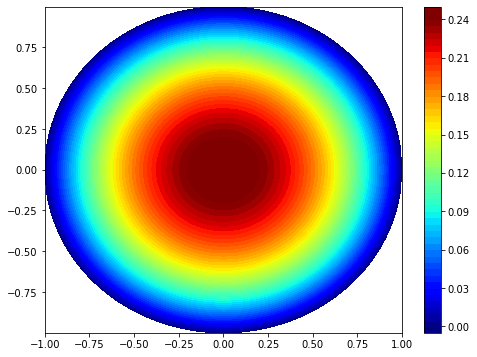

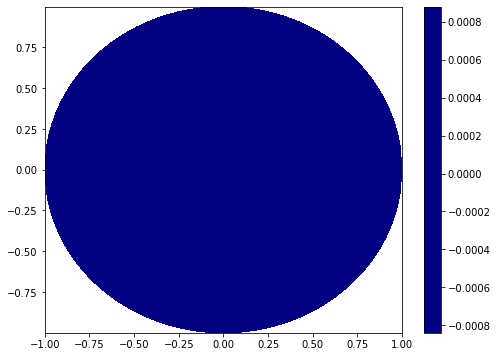

In [56]:
test_u_=torch.reshape(u_test_,(mesh_size,mesh_size))
#设置打开画布大小,长8，宽6
plt.figure(figsize=(8,6))
#填充颜色，f即filled
cset=plt.contourf(mesh1.data.numpy(), y_mesh.data.numpy(),test_u_.data.numpy(), 50, cmap="jet")
#画等高线
#plt.contour(x1,x2,test_u_,50)
#设置颜色条
plt.clim(0.00, 0.24)
plt.colorbar(cset)
plt.show()

prediciton_u_=torch.reshape(prediction_u.data,(mesh_size,mesh_size))
#设置打开画布大小,长8，宽6
plt.figure(figsize=(8,6))
#填充颜色，f即filled
cset=plt.contourf(mesh1.data.numpy(),y_mesh.data.numpy(),prediciton_u_.data.numpy(), 50, cmap="jet")
#画等高线
#plt.contour(x1,x2,test_u_,50)
#设置颜色
plt.clim(0.00, 0.24)
plt.colorbar(cset)
plt.show()


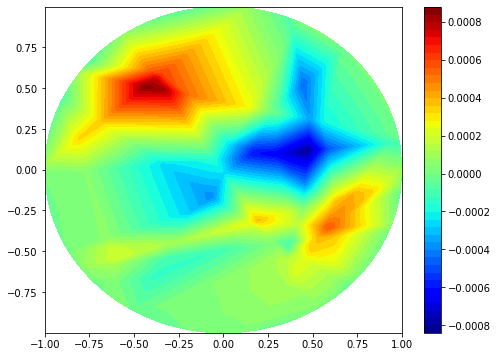

In [57]:
prediciton_u_=torch.reshape(prediction_u.data,(mesh_size,mesh_size))
#设置打开画布大小,长8，宽6
plt.figure(figsize=(8,6))
#填充颜色，f即filled
cset=plt.contourf(mesh1.data.numpy(),y_mesh.data.numpy(),prediciton_u_.data.numpy(), 50, cmap="jet")
#画等高线
#plt.contour(x1,x2,test_u_,50)
#设置颜色
#plt.clim(0.00, 0.24)
plt.colorbar(cset)
plt.show()

In [58]:
iteration = 501
n1 = 10
n2 = 10

prediction_u = net_u(x_test_)
prediction_v = net_v(x_test_)


for t in range(iteration):
       
        
    for i in range(n1):
        loss_u = Loss_u(prediction_u, prediction_v)
        optimizer_u.zero_grad()
        loss_u.backward(retain_graph=True)
        optimizer_u.step()
        #scheduler_u.step() #loss_u
        prediction_u = net_u(x_test_)
        
    
    for j in range(n2):
        loss_v = Loss_v(prediction_u, prediction_v)
        optimizer_v.zero_grad()
        loss_v.backward(retain_graph=True)
        optimizer_v.step()
        #scheduler_v.step() #loss_v
        prediction_v = net_v(x_test_)
            

    if t%10==0:
        print(t, loss_u, loss_v)
        print('第%d个epoch的学习率：%f'%(t, optimizer_u.param_groups[0]['lr']))
        print('第%d个epoch的学习率：%f'%(t, optimizer_v.param_groups[0]['lr']))

0 tensor(2.2998, grad_fn=<AddBackward0>) tensor(-2.3361, grad_fn=<NegBackward>)
第0个epoch的学习率：0.000750
第0个epoch的学习率：0.002000
10 tensor(2.1082, grad_fn=<AddBackward0>) tensor(-2.0812, grad_fn=<NegBackward>)
第10个epoch的学习率：0.000750
第10个epoch的学习率：0.002000
20 tensor(2.0840, grad_fn=<AddBackward0>) tensor(-2.0855, grad_fn=<NegBackward>)
第20个epoch的学习率：0.000750
第20个epoch的学习率：0.002000
30 tensor(2.1028, grad_fn=<AddBackward0>) tensor(-2.1044, grad_fn=<NegBackward>)
第30个epoch的学习率：0.000750
第30个epoch的学习率：0.002000
40 tensor(2.1230, grad_fn=<AddBackward0>) tensor(-2.1247, grad_fn=<NegBackward>)
第40个epoch的学习率：0.000750
第40个epoch的学习率：0.002000
50 tensor(2.1460, grad_fn=<AddBackward0>) tensor(-2.1482, grad_fn=<NegBackward>)
第50个epoch的学习率：0.000750
第50个epoch的学习率：0.002000
60 tensor(2.1741, grad_fn=<AddBackward0>) tensor(-2.1769, grad_fn=<NegBackward>)
第60个epoch的学习率：0.000750
第60个epoch的学习率：0.002000
70 tensor(2.2105, grad_fn=<AddBackward0>) tensor(-2.2142, grad_fn=<NegBackward>)
第70个epoch的学习率：0.000750
第70个epoch的

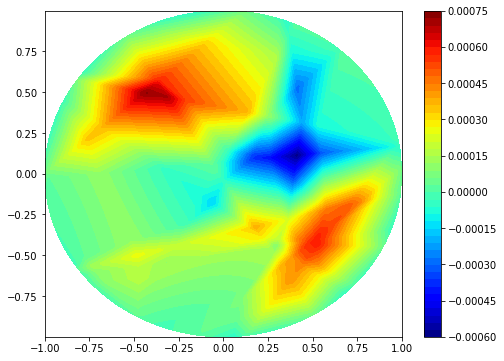

In [59]:
prediciton_u_=torch.reshape(prediction_u.data,(mesh_size,mesh_size))
#设置打开画布大小,长8，宽6
plt.figure(figsize=(8,6))
#填充颜色，f即filled
cset=plt.contourf(mesh1.data.numpy(),y_mesh.data.numpy(),prediciton_u_.data.numpy(), 50, cmap="jet")
#画等高线
#plt.contour(x1,x2,test_u_,50)
#设置颜色
#plt.clim(0.00, 0.24)
plt.colorbar(cset)
plt.show()

In [60]:
iteration = 501
n1 = 10
n2 = 10

prediction_u = net_u(x_test_)
prediction_v = net_v(x_test_)


for t in range(iteration):
       
        
    for i in range(n1):
        loss_u = Loss_u(prediction_u, prediction_v)
        optimizer_u.zero_grad()
        loss_u.backward(retain_graph=True)
        optimizer_u.step()
        #scheduler_u.step() #loss_u
        prediction_u = net_u(x_test_)
        
    
    for j in range(n2):
        loss_v = Loss_v(prediction_u, prediction_v)
        optimizer_v.zero_grad()
        loss_v.backward(retain_graph=True)
        optimizer_v.step()
        #scheduler_v.step() #loss_v
        prediction_v = net_v(x_test_)
            

    if t%10==0:
        print(t, loss_u, loss_v)
        print('第%d个epoch的学习率：%f'%(t, optimizer_u.param_groups[0]['lr']))
        print('第%d个epoch的学习率：%f'%(t, optimizer_v.param_groups[0]['lr']))

0 tensor(2.2563, grad_fn=<AddBackward0>) tensor(-2.2567, grad_fn=<NegBackward>)
第0个epoch的学习率：0.000750
第0个epoch的学习率：0.002000
10 tensor(2.2624, grad_fn=<AddBackward0>) tensor(-2.2629, grad_fn=<NegBackward>)
第10个epoch的学习率：0.000750
第10个epoch的学习率：0.002000
20 tensor(2.2689, grad_fn=<AddBackward0>) tensor(-2.2694, grad_fn=<NegBackward>)
第20个epoch的学习率：0.000750
第20个epoch的学习率：0.002000
30 tensor(2.2758, grad_fn=<AddBackward0>) tensor(-2.2764, grad_fn=<NegBackward>)
第30个epoch的学习率：0.000750
第30个epoch的学习率：0.002000
40 tensor(2.2833, grad_fn=<AddBackward0>) tensor(-2.2839, grad_fn=<NegBackward>)
第40个epoch的学习率：0.000750
第40个epoch的学习率：0.002000
50 tensor(2.2913, grad_fn=<AddBackward0>) tensor(-2.2920, grad_fn=<NegBackward>)
第50个epoch的学习率：0.000750
第50个epoch的学习率：0.002000
60 tensor(2.3001, grad_fn=<AddBackward0>) tensor(-2.3008, grad_fn=<NegBackward>)
第60个epoch的学习率：0.000750
第60个epoch的学习率：0.002000
70 tensor(2.3096, grad_fn=<AddBackward0>) tensor(-2.3105, grad_fn=<NegBackward>)
第70个epoch的学习率：0.000750
第70个epoch的

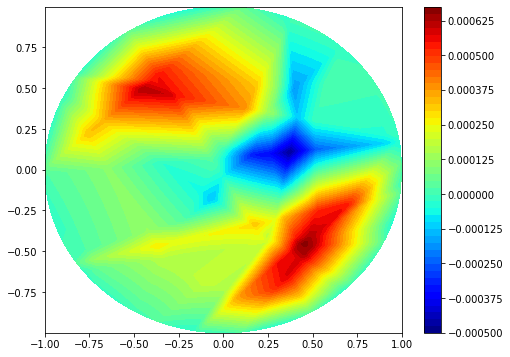

In [61]:
prediciton_u_=torch.reshape(prediction_u.data,(mesh_size,mesh_size))
#设置打开画布大小,长8，宽6
plt.figure(figsize=(8,6))
#填充颜色，f即filled
cset=plt.contourf(mesh1.data.numpy(),y_mesh.data.numpy(),prediciton_u_.data.numpy(), 50, cmap="jet")
#画等高线
#plt.contour(x1,x2,test_u_,50)
#设置颜色
#plt.clim(0.00, 0.24)
plt.colorbar(cset)
plt.show()

In [62]:
iteration = 501
n1 = 10
n2 = 10

prediction_u = net_u(x_test_)
prediction_v = net_v(x_test_)


for t in range(iteration):
       
        
    for i in range(n1):
        loss_u = Loss_u(prediction_u, prediction_v)
        optimizer_u.zero_grad()
        loss_u.backward(retain_graph=True)
        optimizer_u.step()
        #scheduler_u.step() #loss_u
        prediction_u = net_u(x_test_)
        
    
    for j in range(n2):
        loss_v = Loss_v(prediction_u, prediction_v)
        optimizer_v.zero_grad()
        loss_v.backward(retain_graph=True)
        optimizer_v.step()
        #scheduler_v.step() #loss_v
        prediction_v = net_v(x_test_)
            

    if t%10==0:
        print(t, loss_u, loss_v)
        print('第%d个epoch的学习率：%f'%(t, optimizer_u.param_groups[0]['lr']))
        print('第%d个epoch的学习率：%f'%(t, optimizer_v.param_groups[0]['lr']))

0 tensor(2.3278, grad_fn=<AddBackward0>) tensor(-2.3281, grad_fn=<NegBackward>)
第0个epoch的学习率：0.000750
第0个epoch的学习率：0.002000
10 tensor(2.3325, grad_fn=<AddBackward0>) tensor(-2.3329, grad_fn=<NegBackward>)
第10个epoch的学习率：0.000750
第10个epoch的学习率：0.002000
20 tensor(2.3375, grad_fn=<AddBackward0>) tensor(-2.3379, grad_fn=<NegBackward>)
第20个epoch的学习率：0.000750
第20个epoch的学习率：0.002000
30 tensor(2.3429, grad_fn=<AddBackward0>) tensor(-2.3433, grad_fn=<NegBackward>)
第30个epoch的学习率：0.000750
第30个epoch的学习率：0.002000
40 tensor(2.3485, grad_fn=<AddBackward0>) tensor(-2.3490, grad_fn=<NegBackward>)
第40个epoch的学习率：0.000750
第40个epoch的学习率：0.002000
50 tensor(2.3546, grad_fn=<AddBackward0>) tensor(-2.3551, grad_fn=<NegBackward>)
第50个epoch的学习率：0.000750
第50个epoch的学习率：0.002000
60 tensor(2.3611, grad_fn=<AddBackward0>) tensor(-2.3617, grad_fn=<NegBackward>)
第60个epoch的学习率：0.000750
第60个epoch的学习率：0.002000
70 tensor(2.3683, grad_fn=<AddBackward0>) tensor(-2.3689, grad_fn=<NegBackward>)
第70个epoch的学习率：0.000750
第70个epoch的

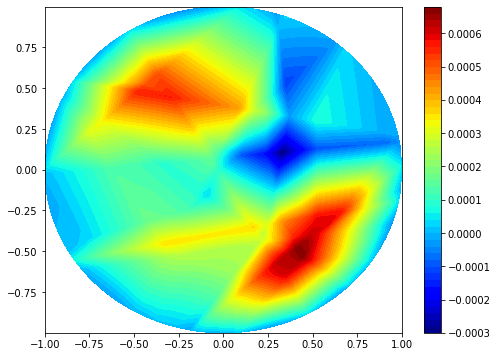

In [63]:
prediciton_u_=torch.reshape(prediction_u.data,(mesh_size,mesh_size))
#设置打开画布大小,长8，宽6
plt.figure(figsize=(8,6))
#填充颜色，f即filled
cset=plt.contourf(mesh1.data.numpy(),y_mesh.data.numpy(),prediciton_u_.data.numpy(), 50, cmap="jet")
#画等高线
#plt.contour(x1,x2,test_u_,50)
#设置颜色
#plt.clim(0.00, 0.24)
plt.colorbar(cset)
plt.show()

In [64]:
iteration = 501
n1 = 10
n2 = 10

prediction_u = net_u(x_test_)
prediction_v = net_v(x_test_)


for t in range(iteration):
       
        
    for i in range(n1):
        loss_u = Loss_u(prediction_u, prediction_v)
        optimizer_u.zero_grad()
        loss_u.backward(retain_graph=True)
        optimizer_u.step()
        #scheduler_u.step() #loss_u
        prediction_u = net_u(x_test_)
        
    
    for j in range(n2):
        loss_v = Loss_v(prediction_u, prediction_v)
        optimizer_v.zero_grad()
        loss_v.backward(retain_graph=True)
        optimizer_v.step()
        #scheduler_v.step() #loss_v
        prediction_v = net_v(x_test_)
            

    if t%10==0:
        print(t, loss_u, loss_v)
        print('第%d个epoch的学习率：%f'%(t, optimizer_u.param_groups[0]['lr']))
        print('第%d个epoch的学习率：%f'%(t, optimizer_v.param_groups[0]['lr']))

0 tensor(2.3667, grad_fn=<AddBackward0>) tensor(-2.3676, grad_fn=<NegBackward>)
第0个epoch的学习率：0.000750
第0个epoch的学习率：0.002000
10 tensor(2.3815, grad_fn=<AddBackward0>) tensor(-2.3835, grad_fn=<NegBackward>)
第10个epoch的学习率：0.000750
第10个epoch的学习率：0.002000
20 tensor(2.4246, grad_fn=<AddBackward0>) tensor(-2.4334, grad_fn=<NegBackward>)
第20个epoch的学习率：0.000750
第20个epoch的学习率：0.002000
30 tensor(2.0246, grad_fn=<AddBackward0>) tensor(-2.0203, grad_fn=<NegBackward>)
第30个epoch的学习率：0.000750
第30个epoch的学习率：0.002000
40 tensor(2.2392, grad_fn=<AddBackward0>) tensor(-2.2991, grad_fn=<NegBackward>)
第40个epoch的学习率：0.000750
第40个epoch的学习率：0.002000
50 tensor(2.3901, grad_fn=<AddBackward0>) tensor(-2.3925, grad_fn=<NegBackward>)
第50个epoch的学习率：0.000750
第50个epoch的学习率：0.002000
60 tensor(2.4476, grad_fn=<AddBackward0>) tensor(-2.4607, grad_fn=<NegBackward>)
第60个epoch的学习率：0.000750
第60个epoch的学习率：0.002000
70 tensor(1.8452, grad_fn=<AddBackward0>) tensor(-1.8452, grad_fn=<NegBackward>)
第70个epoch的学习率：0.000750
第70个epoch的

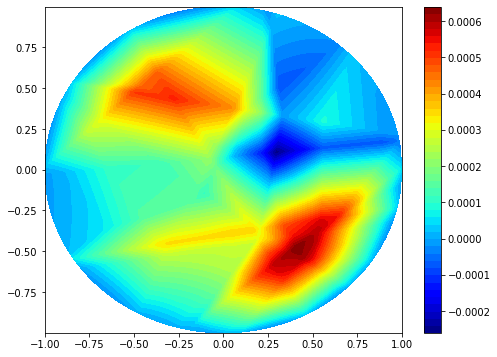

In [65]:
prediciton_u_=torch.reshape(prediction_u.data,(mesh_size,mesh_size))
#设置打开画布大小,长8，宽6
plt.figure(figsize=(8,6))
#填充颜色，f即filled
cset=plt.contourf(mesh1.data.numpy(),y_mesh.data.numpy(),prediciton_u_.data.numpy(), 50, cmap="jet")
#画等高线
#plt.contour(x1,x2,test_u_,50)
#设置颜色
#plt.clim(0.00, 0.24)
plt.colorbar(cset)
plt.show()

In [66]:
iteration = 501
n1 = 10
n2 = 10

prediction_u = net_u(x_test_)
prediction_v = net_v(x_test_)


for t in range(iteration):
       
        
    for i in range(n1):
        loss_u = Loss_u(prediction_u, prediction_v)
        optimizer_u.zero_grad()
        loss_u.backward(retain_graph=True)
        optimizer_u.step()
        #scheduler_u.step() #loss_u
        prediction_u = net_u(x_test_)
        
    
    for j in range(n2):
        loss_v = Loss_v(prediction_u, prediction_v)
        optimizer_v.zero_grad()
        loss_v.backward(retain_graph=True)
        optimizer_v.step()
        #scheduler_v.step() #loss_v
        prediction_v = net_v(x_test_)
            

    if t%10==0:
        print(t, loss_u, loss_v)
        print('第%d个epoch的学习率：%f'%(t, optimizer_u.param_groups[0]['lr']))
        print('第%d个epoch的学习率：%f'%(t, optimizer_v.param_groups[0]['lr']))

0 tensor(2.3936, grad_fn=<AddBackward0>) tensor(-2.3941, grad_fn=<NegBackward>)
第0个epoch的学习率：0.000750
第0个epoch的学习率：0.002000
10 tensor(2.4012, grad_fn=<AddBackward0>) tensor(-2.4022, grad_fn=<NegBackward>)
第10个epoch的学习率：0.000750
第10个epoch的学习率：0.002000
20 tensor(2.4189, grad_fn=<AddBackward0>) tensor(-2.4217, grad_fn=<NegBackward>)
第20个epoch的学习率：0.000750
第20个epoch的学习率：0.002000
30 tensor(2.7062, grad_fn=<AddBackward0>) tensor(-2.0451, grad_fn=<NegBackward>)
第30个epoch的学习率：0.000750
第30个epoch的学习率：0.002000
40 tensor(1.8520, grad_fn=<AddBackward0>) tensor(-1.8557, grad_fn=<NegBackward>)
第40个epoch的学习率：0.000750
第40个epoch的学习率：0.002000
50 tensor(1.9003, grad_fn=<AddBackward0>) tensor(-1.9057, grad_fn=<NegBackward>)
第50个epoch的学习率：0.000750
第50个epoch的学习率：0.002000
60 tensor(1.9781, grad_fn=<AddBackward0>) tensor(-1.9879, grad_fn=<NegBackward>)
第60个epoch的学习率：0.000750
第60个epoch的学习率：0.002000
70 tensor(2.1663, grad_fn=<AddBackward0>) tensor(-2.2042, grad_fn=<NegBackward>)
第70个epoch的学习率：0.000750
第70个epoch的

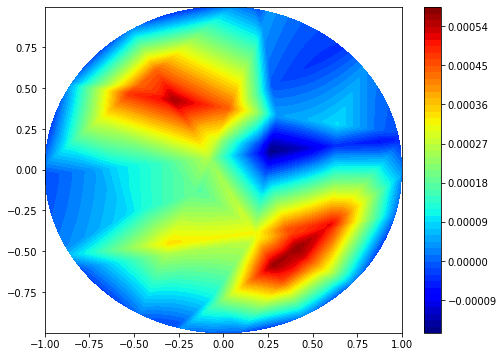

In [67]:
prediciton_u_=torch.reshape(prediction_u.data,(mesh_size,mesh_size))
#设置打开画布大小,长8，宽6
plt.figure(figsize=(8,6))
#填充颜色，f即filled
cset=plt.contourf(mesh1.data.numpy(),y_mesh.data.numpy(),prediciton_u_.data.numpy(), 50, cmap="jet")
#画等高线
#plt.contour(x1,x2,test_u_,50)
#设置颜色
#plt.clim(0.00, 0.24)
plt.colorbar(cset)
plt.show()

In [68]:
iteration = 501
n1 = 10
n2 = 10

prediction_u = net_u(x_test_)
prediction_v = net_v(x_test_)


for t in range(iteration):
       
        
    for i in range(n1):
        loss_u = Loss_u(prediction_u, prediction_v)
        optimizer_u.zero_grad()
        loss_u.backward(retain_graph=True)
        optimizer_u.step()
        #scheduler_u.step() #loss_u
        prediction_u = net_u(x_test_)
        
    
    for j in range(n2):
        loss_v = Loss_v(prediction_u, prediction_v)
        optimizer_v.zero_grad()
        loss_v.backward(retain_graph=True)
        optimizer_v.step()
        #scheduler_v.step() #loss_v
        prediction_v = net_v(x_test_)
            

    if t%10==0:
        print(t, loss_u, loss_v)
        print('第%d个epoch的学习率：%f'%(t, optimizer_u.param_groups[0]['lr']))
        print('第%d个epoch的学习率：%f'%(t, optimizer_v.param_groups[0]['lr']))

0 tensor(2.3492, grad_fn=<AddBackward0>) tensor(-2.3493, grad_fn=<NegBackward>)
第0个epoch的学习率：0.000750
第0个epoch的学习率：0.002000
10 tensor(2.3514, grad_fn=<AddBackward0>) tensor(-2.3516, grad_fn=<NegBackward>)
第10个epoch的学习率：0.000750
第10个epoch的学习率：0.002000
20 tensor(2.3538, grad_fn=<AddBackward0>) tensor(-2.3540, grad_fn=<NegBackward>)
第20个epoch的学习率：0.000750
第20个epoch的学习率：0.002000
30 tensor(2.3564, grad_fn=<AddBackward0>) tensor(-2.3566, grad_fn=<NegBackward>)
第30个epoch的学习率：0.000750
第30个epoch的学习率：0.002000
40 tensor(2.3590, grad_fn=<AddBackward0>) tensor(-2.3593, grad_fn=<NegBackward>)
第40个epoch的学习率：0.000750
第40个epoch的学习率：0.002000
50 tensor(2.3618, grad_fn=<AddBackward0>) tensor(-2.3621, grad_fn=<NegBackward>)
第50个epoch的学习率：0.000750
第50个epoch的学习率：0.002000
60 tensor(2.3648, grad_fn=<AddBackward0>) tensor(-2.3651, grad_fn=<NegBackward>)
第60个epoch的学习率：0.000750
第60个epoch的学习率：0.002000
70 tensor(2.3680, grad_fn=<AddBackward0>) tensor(-2.3682, grad_fn=<NegBackward>)
第70个epoch的学习率：0.000750
第70个epoch的

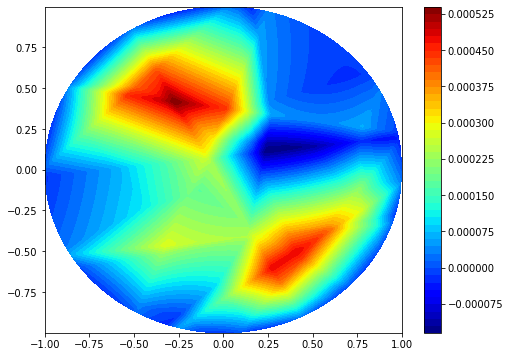

In [69]:
prediciton_u_=torch.reshape(prediction_u.data,(mesh_size,mesh_size))
#设置打开画布大小,长8，宽6
plt.figure(figsize=(8,6))
#填充颜色，f即filled
cset=plt.contourf(mesh1.data.numpy(),y_mesh.data.numpy(),prediciton_u_.data.numpy(), 50, cmap="jet")
#画等高线
#plt.contour(x1,x2,test_u_,50)
#设置颜色
#plt.clim(0.00, 0.24)
plt.colorbar(cset)
plt.show()

In [ ]:
# error
lens=x_test.shape[0]
error_test = torch.Tensor(lens,1)
for i in range(lens):
  error_test[i] = torch.sqrt((torch.square(u_test.data[i]-prediction_u.data[i]))) 

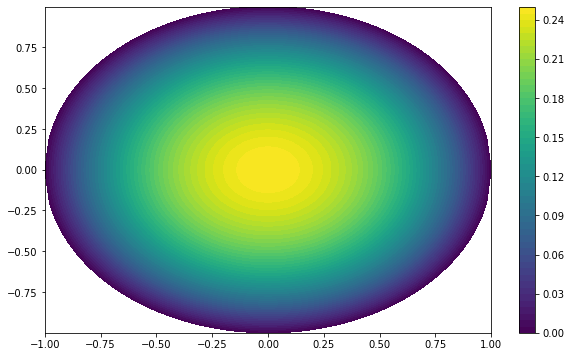

In [ ]:
error_test_=torch.reshape(error_test,(mesh_size,mesh_size))
#设置打开画布大小,长8，宽6
plt.figure(figsize=(8,6))
#填充颜色，f即filled
cset=plt.contourf(mesh1.data.numpy(),y_mesh.data.numpy(),error_test_.data.numpy(), 50)
#画等高线
#plt.contour(x1,x2,test_u_,50)
#设置颜色条
plt.colorbar(cset)
plt.show()